<a href="https://colab.research.google.com/github/hamednasr/transformers/blob/main/Encoder_Decoder_transformers_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Encoder-Decoder Seq2Seq Transformer

In [ ]:
!pip -q install transformers datasets sentencepiece sacremoses

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from datasets import load_dataset
from datetime import datetime
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_v, d_model, n_heads, max_len, causal = False):
    super().__init__()

    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads

    self.W_q = nn.Linear(d_model,d_k*n_heads)
    self.W_k = nn.Linear(d_model,d_k*n_heads)
    self.W_v = nn.Linear(d_model,d_v*n_heads)
    self.fc = nn.Linear(d_v*n_heads, d_model)

    self.causal = causal

    if causal:
      cm = torch.tril(torch.ones(max_len,max_len))
      self.register_buffer('causal_mask', cm.view(1,1,max_len,max_len))


  def forward(self, q, k, v, pad_mask=None):
    Q = self.W_q(q)  # N × T × h*d_k
    K = self.W_k(k)  # N × T × h*d_k
    V = self.W_v(v)  # N × T × h*d_v

    N = Q.shape[0]
    T_output = Q.shape[1] # Q comes from decoder and K,V come from encoder
    T_input = K.shape[1]  # it also works for encoder-decoder transformers

    Q = Q.view(N, T_output, self.n_heads, self.d_k).transpose(1,2) # N × T × h*d_k -->> N × h × T × d_k
    K = K.view(N, T_input, self.n_heads, self.d_k).transpose(1,2) # N × T × h*d_k -->> N × h × T × d_k
    V = V.view(N, T_input, self.n_heads, self.d_k).transpose(1,2) # N × T × h*d_k -->> N × h × T × d_k

    AttentionScores = Q @ K.transpose(2,3) / np.sqrt(self.d_k) #  N × h × T × T

    if pad_mask is not None:
      AttentionScores = AttentionScores.masked_fill(pad_mask[:,None,None,:] == 0, float('-inf'))

    if self.causal:
      AttentionScores = AttentionScores.masked_fill(self.causal_mask[:,:,:T_output,:T_input] == 0, float('-inf'))


    AttentionWeights = F.softmax(AttentionScores, dim=-1) #  N × h × T × T

    A = AttentionWeights @ V #  N × h × T × d_v
    A = A.transpose(1,2).contiguous().view(N, T_output, self.n_heads*self.d_v ) #  N × T × h*d_v

    return self.fc(A)


In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, d_k, d_v, d_model, n_heads, max_len, dropout_prob=0.2):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.mha = MultiHeadAttention(d_k, d_v, d_model, n_heads,max_len,causal=False)
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model*3),
        nn.GELU(),
        nn.Linear(d_model*3, d_model),
        nn.Dropout(dropout_prob)
    )
    self.dropout = nn.Dropout(dropout_prob)

  def forward(self, x, pad_mask= None):
    x = self.ln1(x + self.mha(x,x,x,pad_mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)

    return x

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, d_k, d_v, d_model, n_heads, max_len, dropout_prob=0.2):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.ln3 = nn.LayerNorm(d_model)

    self.mha1 = MultiHeadAttention(d_k, d_v, d_model, n_heads, max_len, causal=True)
    self.mha2 = MultiHeadAttention(d_k, d_v, d_model, n_heads, max_len, causal=False)

    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model*3),
        nn.GELU(),
        nn.Linear(d_model*3, d_model),
        nn.Dropout(dropout_prob)
    )
    self.dropout = nn.Dropout(dropout_prob)

  def forward(self, encoder_output, decoder_input, enc_mask=None, dec_mask=None):
    x = self.ln1(decoder_input + self.mha1(decoder_input, decoder_input, decoder_input, dec_mask)) # first multihead attention
    x = self.ln2(x + self.mha2(x, encoder_output, encoder_output, enc_mask)) # second multihead attention
    x = self.ln3(x + self.ann(x))
    x = self.dropout(x)

    return x

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len = 2048, dropout_prob=0.2):
    super().__init__()
    self.dropout = nn.Dropout(dropout_prob)

    position = torch.arange(max_len).unsqueeze(1)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term * (-np.log(10000.0) / d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position * div_term)
    pe[0, :, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe',pe)

  def forward(self, x):
    x = x+self.pe[:, :x.size(1), :]

    return self.dropout(x)

In [ ]:
class Encoder(nn.Module):

  def __init__(self, vocab_size, max_len,d_model,d_k,d_v,
               n_heads,n_layers,dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size,d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [EncoderBlock(d_k, d_v,
                                        d_model,
                                        n_heads,
                                        max_len,
                                        dropout_prob) for i in range(n_layers)]

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    # self.fc = nn.Linear(d_model, n_classes)

  def forward(self, x, pad_mask=None):
    x = self.embedding(x)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(x, pad_mask)

    # x = x[:,0,:] #many to one: get one of the hidden vectors if it is a one-classfification problem
    x = self.ln(x)
    # x = self.fc(x)  # no need for this in encoder-decoder

    return x


In [ ]:
class Decoder(nn.Module):

  def __init__(self, vocab_size, max_len,d_model,d_k,d_v,
               n_heads,n_layers,dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size,d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [DecoderBlock(d_k, d_v,
                                        d_model,
                                        n_heads,
                                        max_len,
                                        dropout_prob) for i in range(n_layers)]

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    self.fc = nn.Linear(d_model, vocab_size)

  def forward(self, encoder_output, decoder_input, enc_mask=None, dec_mask=None):
    x = self.embedding(decoder_input)
    x = self.pos_encoding(x)

    for block in self.transformer_blocks:
      x = block(encoder_output, x, enc_mask, dec_mask)


    # x = x[:,0,:] #many to one: get one of the hidden vectors if it is a one-classfification problem


    x = self.ln(x)
    x = self.fc(x) # many to many since output of model is a text

    return x


In [ ]:
class Transformer(nn.Module):

  def __init__(self, encoder, decoder):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, encoder_input, decoder_input, enc_mask, dec_mask):
    encoder_output = self.encoder(encoder_input, enc_mask)
    decoder_output = self.decoder(encoder_output, decoder_input, enc_mask, dec_mask)

    return decoder_output


## dummy data and transformer sanity check

In [ ]:
encoder = Encoder(vocab_size=10000,
                  max_len=512,
                  d_model=64,
                  d_k=8,
                  d_v=8,
                  n_heads=6,
                  n_layers=3,
                  dropout_prob=0.1)

decoder = Decoder(vocab_size=20000,
                  max_len=512,
                  d_model=64,
                  d_k=8,
                  d_v=8,
                  n_heads=6,
                  n_layers=3,
                  dropout_prob=0.1)

transformer = Transformer(encoder, decoder)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [ ]:
enc_inp = np.random.randint(0,10000, size=(5,512))
enc_inp = torch.tensor(enc_inp).to(device)

dec_inp = np.random.randint(0,20000, size=(5,512))
dec_inp = torch.tensor(enc_inp).to(device)

maske = np.ones((5,512))
maske[:,256:]= 0
maske = torch.tensor(maske).to(device)

maskd = np.ones((5,512))
maskd[:,128:]= 0
maskd = torch.tensor(maskd).to(device)

In [ ]:
output = transformer(enc_inp, dec_inp, maske, maskd)
output.shape

## download datasaet (english-spanish) convert to csv

In [ ]:
!wget https://lazyprogrammer.me/course_files/nlp3/spa.txt

In [ ]:
df = pd.read_csv('spa.txt',sep='\t',header=None)
df

In [ ]:
# df = df.iloc[:40000,:]
df.columns = ['en','es']
df.to_csv('spa.csv', index=None)

In [ ]:
raw_dataset = load_dataset('csv', data_files='spa.csv')
raw_dataset

In [ ]:
split = raw_dataset['train'].train_test_split(test_size=0.05, seed=5)
split

## tokenization

In [ ]:
checkpoint = 'Helsinki-NLP/opus-mt-en-es'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
split['train']['en'][0], tokenizer(split['train']['en'][0])

In [ ]:
tokenizer.decode([3749, 40, 2207, 58, 35, 21, 0])

In [ ]:
split['train']['es'][0], tokenizer(text_target=split['train']['es'][0])

In [ ]:
target = tokenizer(text_target=split['train']['es'][0])

In [ ]:
tokenizer.convert_ids_to_tokens(target['input_ids'])

## map tokenizer function to all data , preprocess data

In [ ]:
max_input_length=256
max_target_length=256

In [ ]:
def preprocess_fn(batch):
  model_inputs = tokenizer(batch['en'], max_length=max_input_length, truncation=True)
  labels = tokenizer(text_target=batch['en'], max_length=max_target_length, truncation=True)
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [ ]:
tokenized_dataset = split.map(preprocess_fn,
                              batched=True,
                              remove_columns=split['train'].column_names)
tokenized_dataset

In [ ]:
tokenized_dataset['train'][0]

## data collator

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)
data_collator

In [ ]:
data_collator([tokenized_dataset['train'][i] for i in range(6,11)])
#end of sentence token is 0 and
# input padding is 65000 and target padding is -100

## special tokens

In [ ]:
tokenizer.all_special_ids, tokenizer.all_special_tokens

In [ ]:
tokenizer('<unk>') #end of sentence is always added (</s>)

In [ ]:
# this tokenizer does not have start of sentence tokenizer, which is required for decoder part
tokenizer.add_special_tokens({'cls_token':'<s>'})

In [ ]:
tokenizer('<s>')

In [ ]:
tokenizer.all_special_ids, tokenizer.all_special_tokens

In [ ]:
tokenizer.vocab_size # it is actually 65002 , we added <s>

In [ ]:
tokenizer.pad_token_id

## data loader

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(tokenized_dataset['train'],
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=data_collator)

val_loader = DataLoader(tokenized_dataset['test'],
                          batch_size=BATCH_SIZE,
                          collate_fn=data_collator)

In [ ]:
train_loader

In [ ]:
for batch in train_loader:
  for k, v in batch.items():
    print('k:',k,'v.shape:',v.shape)
  break

In [ ]:
for batch in train_loader:
  targets = batch['labels'][:3,:]
  print(targets)
  print('************************************************')
  print(torch.roll(targets,shifts=1,dims=1)) # decoder input
  break

In [ ]:
tokenizer.max_model_input_sizes

## create model

In [ ]:
encoder = Encoder(vocab_size=65002,
                  max_len=512,
                  d_model=32,
                  d_k=8,
                  d_v=8,
                  n_heads=6,
                  n_layers=3,
                  dropout_prob=0.1)

decoder = Decoder(vocab_size=65002,
                  max_len=512,
                  d_model=32,
                  d_k=8,
                  d_v=8,
                  n_heads=6,
                  n_layers=3,
                  dropout_prob=0.1)

model = Transformer(encoder, decoder)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)
# decoder.to(device)

cuda:0


Transformer(
  (encoder): Encoder(
    (embedding): Embedding(65002, 32)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_blocks): Sequential(
      (0): EncoderBlock(
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=32, out_features=48, bias=True)
          (W_k): Linear(in_features=32, out_features=48, bias=True)
          (W_v): Linear(in_features=32, out_features=48, bias=True)
          (fc): Linear(in_features=48, out_features=32, bias=True)
        )
        (ann): Sequential(
          (0): Linear(in_features=32, out_features=96, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=96, out_features=32, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1

In [ ]:
train_loader

## train model

In [ ]:
def TrainModel(model, train_loader, val_loader, epochs):

  trainLoss = []
  testLoss  = []

  lossfun = nn.CrossEntropyLoss(ignore_index=-100)
  optimizer = torch.optim.Adam(model.parameters())


  for epoch in range(epochs):
    model.train()
    t0 = datetime.now()
    trainBatchLoss = []

    for batch in train_loader:
      batch = {k:v.to(device) for k,v in batch.items()}

      encoder_input = batch['input_ids']
      encoder_mask = batch['attention_mask']
      targets = batch['labels']

      decoder_input = targets.clone().detach()
      decoder_input = torch.roll(decoder_input, shifts=1, dims=1)
      decoder_input[:,0] = 65001

      #-100 is not valid for transformers, change to positive value
      decoder_input = decoder_input.masked_fill(decoder_input == -100,tokenizer.pad_token_id)

      decoder_mask = torch.ones_like(decoder_input)
      decoder_mask = decoder_mask.masked_fill(decoder_input == tokenizer.pad_token_id,0)


      model_output = model(encoder_input,decoder_input,encoder_mask,decoder_mask)
      # print(model_output.shape)
      loss = lossfun(model_output.transpose(2,1), targets)


      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      trainBatchLoss.append(loss.item())

    trainLoss.append(np.mean(trainBatchLoss))


    model.eval()
    testBatchLoss = []

    for batch in val_loader:
      batch = {k:v.to(device) for k,v in batch.items()}

      encoder_input = batch['input_ids']
      encoder_mask = batch['attention_mask']
      targets = batch['labels']

      #decoder input is shifted targets
      decoder_input = targets.clone().detach()
      decoder_input = torch.roll(decoder_input, shifts=1, dims=1)
      decoder_input[:,0] = 65001

      #-100 is not valid for transformers, change to positive value
      decoder_input = decoder_input.masked_fill(decoder_input == -100,tokenizer.pad_token_id)

      decoder_mask = torch.ones_like(decoder_input)
      decoder_mask = decoder_mask.masked_fill(decoder_input == tokenizer.pad_token_id,0)


      model_output = model(encoder_input,decoder_input,encoder_mask,decoder_mask)
      # print(model_output.shape)
      loss = lossfun(model_output.transpose(2,1), targets)


      testBatchLoss.append(loss.item())

    # get loss and error rate from the test batch

    testLoss.append(np.mean(testBatchLoss))


    t = datetime.now() - t0

    print(f'Epoch: {epoch}/{epochs},  \
    Train Loss: {trainLoss[epoch].item():.4f},  \
    Test Loss: {testLoss[epoch].item():.4f},  Duration:{t}')


  return trainLoss,testLoss,model

In [ ]:
trainLoss,testLoss,model = TrainModel(model,train_loader,val_loader,epochs=10)

Epoch: 0/10,      Train Loss: 3.5380,      Test Loss: 2.2899,  Duration:0:04:21.215901
Epoch: 1/10,      Train Loss: 2.4368,      Test Loss: 1.7818,  Duration:0:04:28.355232
Epoch: 2/10,      Train Loss: 2.0959,      Test Loss: 1.4393,  Duration:0:04:27.833172
Epoch: 3/10,      Train Loss: 1.8580,      Test Loss: 1.2176,  Duration:0:04:26.441973
Epoch: 4/10,      Train Loss: 1.6817,      Test Loss: 1.0477,  Duration:0:04:30.881243
Epoch: 5/10,      Train Loss: 1.5428,      Test Loss: 0.9290,  Duration:0:04:25.801579
Epoch: 6/10,      Train Loss: 1.4298,      Test Loss: 0.8391,  Duration:0:04:29.338763
Epoch: 7/10,      Train Loss: 1.3359,      Test Loss: 0.7647,  Duration:0:04:26.364620
Epoch: 8/10,      Train Loss: 1.2551,      Test Loss: 0.6979,  Duration:0:04:26.810366
Epoch: 9/10,      Train Loss: 1.1867,      Test Loss: 0.6573,  Duration:0:04:27.008907


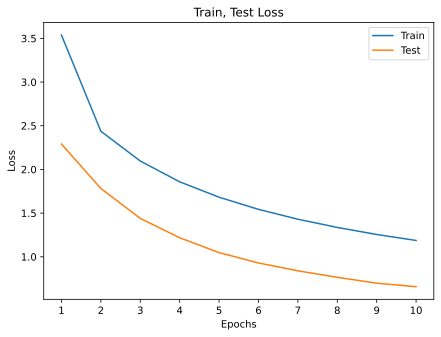

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))

ax.plot(trainLoss,label='Train')
ax.plot(testLoss,label='Test')
ax.set_xticks(ticks=np.arange(0,10), labels=np.arange(0,10)+1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'Train, Test Loss')
ax.legend()

plt.show()

## save and load model

In [ ]:
PATH = 'TranslationModel'
torch.save(model, PATH)

In [ ]:
# model = transformer(encoder,decoder)
PATH = 'TranslationModel'
model = torch.load(PATH)

## test the model

In [ ]:
checkpoint = 'Helsinki-NLP/opus-mt-en-es'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
def translate(text):

  '''after training the transformer, we can use this function
     to translate the given text'''

  encoder_input = tokenizer(text, return_tensors = 'pt').to(device)

  #using decoder in generative mode,decoder input is just a sentence start tag
  #ignore final 0  </s>
  decoder_input = tokenizer(text_target= '<s>' ,return_tensors = 'pt').to(device)

  decoder_input_ids = decoder_input['input_ids'][:,:-1]
  decoder_attention_mask = decoder_input['attention_mask'][:,:-1]

  # pred_id = 1

  for i in range(20): #terminate when reach to the end of sentence (id=0)

    transformer_output = model(encoder_input['input_ids'],
                        decoder_input_ids,
                        encoder_input['attention_mask'],
                        decoder_attention_mask)

    print(transformer_output)
    # print(transformer_output[:,:,-1].shape)
    pred_id = torch.argmax(transformer_output)

    decoder_input_ids = torch.hstack((decoder_input_ids, pred_id.view(1,1)))
    decoder_attention_mask = torch.ones_like(decoder_input_ids)

    if pred_id == 0:
      break

  translation = tokenizer.decode(decoder_input_ids)

  return translation


In [ ]:
translate('how are you doing?!')

In [ ]:
translate('I love you!')

In [ ]:
translate('Edison was raised in the American Midwest. Early in his career he worked as a telegraph operator, which inspired some of his earliest inventions. In 1876, he established his first laboratory facility in Menlo Park, New Jersey, where many of his early inventions were developed.')